# Import and Cleaning

In [1]:
# adding path to import custom functions
import sys
sys.path.append("/home/artur/code/masters-project/main_project/notebooks/model_creation")

In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime

from functions import remove_high_corr, scale_variables, best_params_grid, calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label, get_error_and_auc

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

from ISLP.bart import BART

import session_info 

In [3]:
data = pd.read_csv("../data/pre_processed_pdb_mordred_2d.csv")
data.head()

/tmp/ipykernel_41500/1940003184.py:1: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/pre_processed_pdb_mordred_2d.csv")


,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,SRW05,fda_approved
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,1.0,0.0,1.0
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,0.5,0.0,1.0
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,0.5,0.0,1.0
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,0.5,0.0,1.0
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,1.0,0.0,1.0


In [4]:
Y = data["fda_approved"]
Y = Y.astype(float)
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: fda_approved, dtype: float64

In [5]:
X = data.iloc[:, 14:-1]
X.head()

,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,VR3_A,nAromAtom,nSpiro,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,SRW05
0,2.449490,0.0,3.000000e+00,1.732051,0.866025,1.931852,5.583629,0.803548,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,1.0,0.0
1,3.047207,0.0,1.110223e-16,1.847759,1.045250,2.130986,8.629874,1.462083,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,0.5,0.0
2,3.047207,0.0,1.110223e-16,1.847759,1.045250,2.130986,8.629874,1.462083,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,0.5,0.0
3,2.121320,0.0,1.000000e+00,1.618034,1.118034,1.946498,5.891993,0.857304,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,0.5,0.0
4,2.449490,0.0,1.110223e-16,1.732051,0.866025,1.931852,5.583629,0.803548,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,1.734723e-18,0.0,0.0,0.0,1.0,0.0


In [6]:
# separate train an test datasets

np.random.seed(750059)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Constant Variables

In [7]:
DESCRIPTOR_TYPE = "mordred"

# Scaling datsets

The datasets are being scaled to be used, when necessary, scaled

In [8]:
# TRAIN
x_train_scaled = scale_variables(x_train)

# adding constant
x_train_scaled = sm.add_constant(x_train_scaled)

x_train_scaled.head()

,const,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,VR3_A,nAromAtom,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,SRW05
0,1.0,-0.747161,-0.479647,-0.518778,-0.122937,-0.170939,-0.591246,-0.019183,-0.918446,-0.603209,...,0.729432,1.248557,1.196812,0.640386,1.499423,0.180397,-1.703257,-1.406161,-0.959561,0.644125
1,1.0,-0.892816,0.572983,-0.518778,-1.325669,-1.206940,-1.338620,-0.019183,-0.727966,-1.455680,...,0.653917,-0.835196,0.254794,-1.335757,0.094096,1.257407,0.081764,-1.406161,-0.959561,0.644125
2,1.0,-0.892907,-0.479647,-0.518778,-0.249045,-0.436497,-1.050824,-0.019183,-1.118767,-0.176973,...,1.029268,-0.438332,2.118940,0.249781,2.352375,-2.058032,-1.703257,-1.406161,-1.393315,0.644125
3,1.0,-0.486730,-0.479647,-0.518778,0.031003,-0.293828,-0.442330,-0.019183,-0.445189,-0.603209,...,1.250737,-0.080792,0.961981,-0.367263,0.598547,0.127250,0.872193,0.071842,0.775454,-1.055445
4,1.0,-0.506477,-0.479647,-0.518778,0.624042,0.512896,-0.182120,-0.019183,-0.618327,-0.176973,...,0.827757,0.397068,0.297369,0.358597,1.248796,0.802388,-0.157987,-1.406161,0.775454,1.102438


In [9]:
# TEST
x_test_scaled = scale_variables(x_test)

# adding constant
x_test_scaled = sm.add_constant(x_test_scaled)

x_test_scaled.head()

,const,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,VR3_A,nAromAtom,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,SRW05
0,1.0,-0.949818,-0.499348,0.047152,-1.125587,-0.622870,-1.188369,-0.032601,-1.110593,-0.570480,...,-0.371717,0.996703,0.957105,0.720049,0.996364,-1.919591,-1.614426,-1.420145,0.781951,-1.099043
1,1.0,-0.170490,-0.499348,-0.591418,1.064460,-0.617222,-0.141302,-0.032601,-0.011500,0.253305,...,1.201378,0.878208,1.145377,1.114929,0.025990,1.751536,1.353676,0.912194,0.781951,0.589079
2,1.0,0.155114,1.545500,-0.591418,0.330421,0.547297,0.542395,-0.032601,0.073690,0.939792,...,0.295183,-0.396453,-0.834452,-0.673114,-0.422390,0.066103,0.491843,0.325428,-0.282388,0.589079
3,1.0,-0.785319,-0.499348,0.047152,-1.069821,-1.960134,-0.820885,-0.032601,-0.927184,-0.570480,...,0.664224,1.681691,0.366668,0.235019,3.355795,-0.649452,-1.614426,-1.420145,0.781951,-1.099043
4,1.0,-0.394264,0.523076,0.047152,-0.371701,-0.839898,0.065391,-0.032601,-0.466857,0.253305,...,0.432500,1.186564,-0.404320,1.958826,0.220964,0.432518,0.942693,0.867020,-0.434437,-1.099043


# Logistic Regression

## Model Constant Variables

In [10]:
model_name_title = "Logistic Regression"
model_name_path = "logistic_regression"

## Cross Validation

Here, I will use the best_params_grid function, which looks for the best hyperparameters, using CV. There are no hyperparameters in Logistic Regression, so this function will only perform CV.

In [11]:
model_params_lr = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {}
    }
}

In [12]:
gs_result_lr, gs_result_lr_full = best_params_grid(x_train, y_train, model_params_lr)

Starting Grid Search for Logistic Regression: 19:10


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Finished Grid Search for Logistic Regression: 19:10
Tempo de execução:  0.1 minutos


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
gs_result_lr

,model,best_score,best_params
0,Logistic Regression,0.677544,{}


## Calculating Logistic Regression in R

## Saving Datasets to use in R

The logistic regression calculation was presenting problems in Python, so it will be performed in R, in a separate notebook, saved in the folder `logistic_regression`. Here, I will save the training and test datasets, to use them in R.

In [14]:
# reseting indices
x_train_scaled = x_train_scaled.reset_index()
x_test_scaled = x_test_scaled.reset_index()

y_train = y_train.reset_index()
y_test = y_test.reset_index()

In [15]:
# joining x and y training and test datasets
train = pd.concat([x_train_scaled, y_train], axis=1).drop(["index"], axis=1)
test = pd.concat([x_test_scaled, y_test], axis=1).drop(["index"], axis=1)

In [16]:
# saving datasets
train.to_csv(f"logistic_regression/data/train_{DESCRIPTOR_TYPE}.csv")
test.to_csv(f"logistic_regression/data/test_{DESCRIPTOR_TYPE}.csv")

## Importing results from R

In [17]:
results_log_reg_df = pd.read_csv(f"logistic_regression/data/lr_coefficients_{DESCRIPTOR_TYPE}.csv")
results_log_reg_df.head()

,Unnamed: 0,Estimate,Std. Error,z value,Pr(>|z|)
0,(Intercept),0.444055,3.326285,0.133499,8.937990e-01
1,X,-0.000102,0.000086,-1.183141,2.367532e-01
2,ABC,-52.421085,17.327306,-3.025345,2.483494e-03
3,nAcid,-0.165200,0.307872,-0.536587,5.915530e-01
4,nBase,1.422537,0.286479,4.965595,6.849066e-07


In [18]:
# y predict in test set
y_predict_lr_prob = pd.read_csv(f"logistic_regression/data/y_predict_proba_test_{DESCRIPTOR_TYPE}.csv")
y_predict_lr_prob = y_predict_lr_prob["x"]
y_predict_lr_prob.head()

0    0.505084
1    0.998696
2    0.082050
3    0.000878
4    1.000000
Name: x, dtype: float64

In [19]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

make_label_v = np.vectorize(make_label)
y_predict_labels_lr = make_label_v(y_predict_lr_prob)

In [20]:
# y predict in training set
y_predict_lr_prob_train = pd.read_csv(f"logistic_regression/data/y_predict_proba_train_{DESCRIPTOR_TYPE}.csv")
y_predict_lr_prob_train = y_predict_lr_prob_train["x"]
y_predict_lr_prob_train.head()

0    0.205927
1    0.997735
2    0.153622
3    0.591923
4    0.440130
Name: x, dtype: float64

## Get Training Error and AUC

In [21]:
mis_rate_lr_train, auc_lr_train = get_error_and_auc(
    model=y_predict_lr_prob_train, 
    x=x_train_scaled,
    y_true=y_train["fda_approved"],
    transform_prob_into_label=True,
    log_reg=True
)

Training Misclassification Rate: 0.1358
Training AUC: 0.8642


## Test Error

In [22]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test["fda_approved"], 
    y_pred=y_predict_labels_lr,
)

Misclassification rate: 0.4473


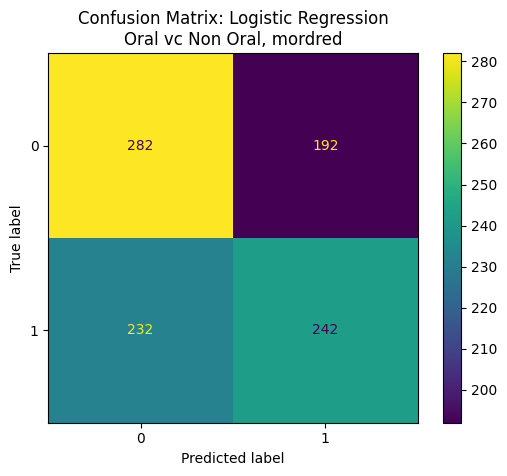

In [23]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

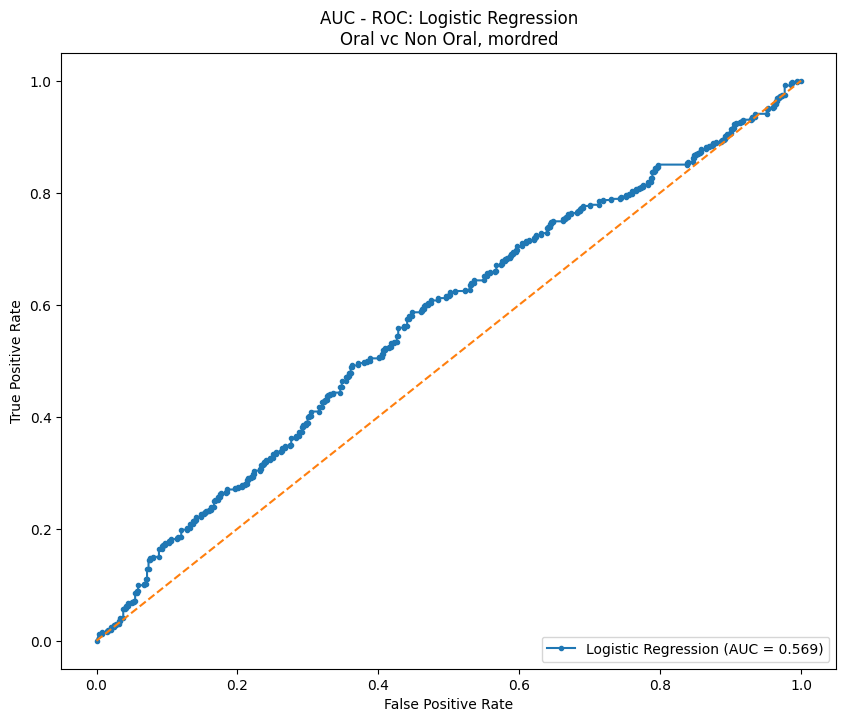

In [24]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test["fda_approved"],
    y_pred=y_predict_lr_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

In [25]:
# converting results summary to pandas dataframe
results_log_reg_df = results_log_reg_df.rename(columns={"Unnamed: 0": "descriptor_name"})
results_log_reg_df = results_log_reg_df.set_index(results_log_reg_df["descriptor_name"]).drop("descriptor_name", axis=1)
results_log_reg_df.shape
results_log_reg_df.head()

,Estimate,Std. Error,z value,Pr(>|z|)
descriptor_name,,,,
(Intercept),0.444055,3.326285,0.133499,8.937990e-01
X,-0.000102,0.000086,-1.183141,2.367532e-01
ABC,-52.421085,17.327306,-3.025345,2.483494e-03
nAcid,-0.165200,0.307872,-0.536587,5.915530e-01
nBase,1.422537,0.286479,4.965595,6.849066e-07


In [26]:
important_features_lr = results_log_reg_df[results_log_reg_df["Pr(>|z|)"] < 0.05]
important_features_lr = important_features_lr.reindex(important_features_lr['Estimate'].abs().sort_values(ascending=False).index)
print(important_features_lr.shape)
important_features_lr

(105, 4)


,Estimate,Std. Error,z value,Pr(>|z|)
descriptor_name,,,,
ABC,-52.421085,17.327306,-3.025345,2.483494e-03
ATS0Z,34.675822,12.092006,2.867665,4.135131e-03
AATS1p,23.377359,5.103505,4.580648,4.635372e-06
nAromAtom,-19.637526,9.542159,-2.057975,3.959253e-02
AATS1i,19.469069,3.912497,4.976123,6.487039e-07
...,...,...,...,...
AATSC7i,-0.713611,0.347392,-2.054194,3.995690e-02
NdS,-0.633895,0.318736,-1.988778,4.672573e-02
MDEC.13,-0.602620,0.297800,-2.023570,4.301439e-02


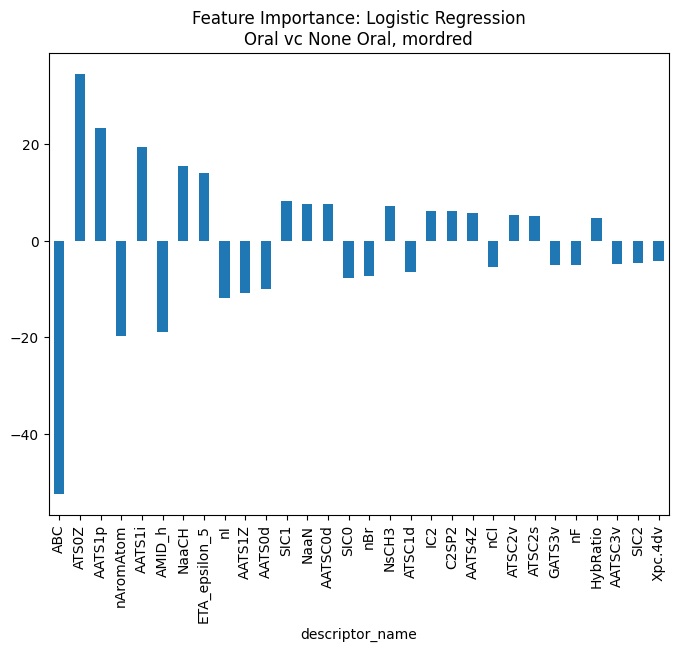

In [27]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

important_features_lr.iloc[:30,0].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

## Saving Results

In [28]:
# creating dataset to store final results from each model
final_results = pd.DataFrame(
    columns=[
        "model_name", 
        "cv_test_auc", 
        "training_mis_rate", 
        "test_mis_rate", 
        "training_auc",
        "test_auc"
    ]
)

In [29]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_lr["best_score"][0],
    mis_rate_lr_train,
    mis_rate_lr,
    auc_lr_train,
    auc_lr
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.677544,0.13582,0.447257,0.86418,0.568525


In [30]:
important_features_lr.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

In [ ]:
results_original = pd.read_csv(f"final_results/models_results_{DESCRIPTOR_TYPE}.csv")
results_original

In [31]:
for i in range(1, 6):
    results_original.iloc[0,i] = final_results.iloc[0,i]
results_original.to_csv(f"final_results/models_results_{DESCRIPTOR_TYPE}.csv")

In [ ]:
results_original = pd.read_csv(f"final_results/models_results_{DESCRIPTOR_TYPE}.csv", index_col=0)
for i in range(1, 6):
    results_original.iloc[0,i] = final_results.iloc[0,i]
results_original.to_csv(f"final_results/models_results_{DESCRIPTOR_TYPE}.csv")

# TREES

# Decision Tree

## Model Constant Variables

In [ ]:
model_name_title = "Decision Tree"
model_name_path = "decision_tree"

## Hyperparameter Fine Tuning

In [ ]:
model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [1, 5, 10, 20, 50, 100, 150],
            'ccp_alpha': [0, 0.0001, 0.001, 0.1, 0.5, 1]
        }
    }
}

In [ ]:
gs_result_dt, gs_result_dt_full = best_params_grid(x_train, y_train, model_params)

In [ ]:
gs_result_dt

## Fitting Tree

In [ ]:
decision_tree_params = gs_result_dt.iloc[0,2]
decision_tree_params

In [ ]:
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train, y_train)

## Get Training Error and AUC

In [ ]:
mis_rate_dt_train, auc_dt_train = get_error_and_auc(
    model=decision_tree, 
    x=x_train,
    y_true=y_train,
)

## Make Predictions

In [ ]:
y_predict_dt_label = decision_tree.predict(x_test)
y_predict_dt_prob = decision_tree.predict_proba(x_test)[:, 1]

## Test Error

In [ ]:
mis_rate_dt, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_dt_label,
)

In [ ]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

In [ ]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Visualizing the Tree

In [ ]:
fig, ax = plt.subplots()
fig.dpi = 1000

tree.plot_tree(decision_tree, ax=ax, feature_names=list(x_train.columns))
plt.show()

fig.savefig(f"imgs/decision_tree_{DESCRIPTOR_TYPE}", dpi=1000)

## Feature Importance

In [ ]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(decision_tree.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [ ]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_dt

## Saving Results

In [ ]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_dt["best_score"][0],
    mis_rate_dt_train,
    mis_rate_dt,
    auc_dt_train,
    auc_dt
]
final_results

In [ ]:
important_features_dt.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Random Forest and Bagging

Bagging is just Random Forest, in which max_features is equal to the total number of features. Therefore, bagging will be done in the RF algorithm, and compared to RF.

## Model Constant Variables

In [ ]:
model_name_title = "Random Forest"
model_name_path = "random_forest"

## Hyperparameter Fine Tuning

In [ ]:
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 500, 1000], # number of trees
            'max_depth': [10, 50, 100],
            'max_features': ["sqrt", "log2"], # m, number of features considered in split. When it is equal to all predictor of dataset, it is bagging
            'ccp_alpha': [0.1, 0.5]
        }
    }
}

In [ ]:
gs_result_rf, gs_result_rf_full = best_params_grid(x_train, y_train, model_params)

In [ ]:
gs_result_rf

## Fitting Model

In [ ]:
random_forest_params = gs_result_rf.iloc[0,2]
random_forest_params

In [ ]:
random_forest = RandomForestClassifier(**random_forest_params).fit(x_train, y_train)

## Get Training Error and AUC

In [ ]:
mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=random_forest, 
    x=x_train,
    y_true=y_train,
)

## Make Predictions

In [ ]:
y_predict_rf_label = random_forest.predict(x_test)
y_predict_rf_prob = random_forest.predict_proba(x_test)[:, 1]

## Test Error

In [ ]:
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_rf_label,
)

In [ ]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

In [ ]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

In [ ]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(random_forest.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [ ]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_rf

## Saving Results

In [ ]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_rf["best_score"][0],
    mis_rate_rf_train,
    mis_rate_rf,
    auc_rf_train,
    auc_rf
]
final_results

In [ ]:
important_features_rf.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Boosting

## Model Constant Variables

In [ ]:
model_name_title = "Gradiant Boosting"
model_name_path = "boosting"

## Hyperparameter Fine Tuning

In [ ]:
model_params = {
    'Boosting': {
            'model': GradientBoostingClassifier(),
            'params': {
                'n_estimators' : [100, 500], # number of trees
                'learning_rate': [0.01, 0.1], # alfa
                'max_depth': [20],
        }
    }
}

In [ ]:
gs_result_boo, gs_result_boo_full = best_params_grid(x_train_scaled, y_train, model_params)

In [ ]:
gs_result_boo

## Fitting Model

In [ ]:
boosting_params = gs_result_boo.iloc[0,2]
boosting_params

In [ ]:
boosting = GradientBoostingClassifier(**boosting_params).fit(x_train, y_train)

## Get Training Error and AUC

In [ ]:
mis_rate_boo_train, auc_boo_train = get_error_and_auc(
    model=boosting, 
    x=x_train,
    y_true=y_train,
)

## Make Prediction

In [ ]:
y_predict_boo_label = boosting.predict(x_test)
y_predict_boo_prob = boosting.predict_proba(x_test)[:, 1]

## Test Error

In [ ]:
mis_rate_boo, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_boo_label,
)

In [ ]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

In [ ]:
auc_boo = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boo_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

In [ ]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(boosting.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [ ]:
important_features_boo = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_boo

## Saving Results

In [ ]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_boo["best_score"][0],
    mis_rate_boo_train,
    mis_rate_boo,
    auc_boo_train,
    auc_boo
]
final_results

In [ ]:
important_features_boo.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# BART

## Model Constant Variables

In [ ]:
model_name_title = "BART"
model_name_path = "bart"

## Hyperparameter Fine Tuning

In [ ]:
# transforming x train and test as arrays for BART procedure

x_train_bart = np.asarray(x_train)
x_test_bart = np.asarray(x_test)

In [ ]:
model_params = {
    'BART': {
        'model': BART(),
        'params': {
            'num_trees': [100, 500, 1000],
            'max_stages': [100, 500, 800, 1000], # B, number of iterations
            'burnin': [5, 10, 20] #L
        }
    }
}

For BART, the auc present in the best_params_grid need to recieve the y_predicted in labels, but this BART algorithm does it in probabilities. Because of this, I need to use a custom scorer, that first transforms the prediction to labels.

In [ ]:
score = make_scorer(bart_auc_scorer, greater_is_better=True)

gs_result_bart, gs_result_bart_full = best_params_grid(x_train_bart, y_train, model_params, scoring=score)

In [ ]:
gs_result_bart

# Fitting Model

In [ ]:
bart_params = gs_result_bart.iloc[0,2]
bart_params

In [ ]:
bart = BART(**bart_params)
bart.fit(x_train_bart, y_train)

## Get Training Error and AUC

In [ ]:
mis_rate_bart_train, auc_bart_train = get_error_and_auc(
    model=bart, 
    x=x_train_bart,
    y_true=y_train,
    transform_prob_into_label=True
)

## Make Prediction

In [ ]:
# the bart algorithm predicts as probabilities
y_predict_bart_prob = bart.predict(x_test_bart)

In [ ]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

y_predict_bart_label = make_label_v(y_predict_bart_prob)

## Test Error

In [ ]:
mis_rate_bart, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_bart_label,
)

In [ ]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

In [ ]:
auc_bart = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_bart_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

We can check how many times each variable appeared in the collection
of trees. This gives a summary similar to the variable importance plot for
boosting and random forests.

In [ ]:
# Print the feature importances
fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(columns=["Importance"])
feat_importances["Importance"] = pd.Series(bart.variable_inclusion_.mean(0),index=X.columns).sort_values(ascending=False)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)


In [ ]:
important_features_bart = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_bart

## Saving Results

In [ ]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_bart["best_score"][0],
    mis_rate_bart_train,
    mis_rate_bart,
    auc_bart_train,
    auc_bart
]
final_results

In [ ]:
important_features_bart.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# SVM

## Model Constant Variables

In [ ]:
model_name_title = "SVM"
model_name_path = "svm"

## Hyperparameter Fine Tuning

In [ ]:
scale = 1 / (x_train.shape[1] * x_train.var().mean())

model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 0.3, 0.5, 0.8, 1.0, 2, 5, 10],
            'kernel': ['rbf', 'sigmoid'],
            'gamma': ['auto', scale, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10]
        }
    }
}

In [ ]:
gs_result_svm, gs_result_svm_full = best_params_grid(x_train, y_train, model_params)

## Fitting Model

In [ ]:
svm_params = gs_result_svm.iloc[0,2]
svm_params

In [ ]:
svm = SVC(**svm_params, probability=True).fit(x_train, y_train)

## Get Training Error and AUC

In [ ]:
mis_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm, 
    x=x_train,
    y_true=y_train,
)

## Make Prediction

In [ ]:
y_predict_svm_label = svm.predict(x_test)
y_predict_svm_prob = svm.predict_proba(x_test)[:, 1]

## Test Error

In [ ]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_svm_label,
)

In [ ]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

In [ ]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Saving Results

In [ ]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_svm["best_score"][0],
    mis_rate_svm_train,
    mis_rate_svm,
    auc_svm_train,
    auc_svm
]
final_results

# Saving Final Datasets

In [ ]:
# saving final_results dataset
final_results.to_csv(f"final_results/models_results_{DESCRIPTOR_TYPE}.csv", index=False)

In [ ]:
session_info.show()